# Objekttracking nach Steinacker et al. (2000)

Im Artikel von Steinacker et al. (2000) gibt es einen interessanten Ansatz um Radarobjekte zu verfolgen. Den sollten wir mal ausprobieren. Der Ansatz besteht aus drei Schritten:

1. Eingangsdaten werden mit einem Gaußfilter geglättet,
2. isolierte Extrema werden identifiziert,
3. Anwendung mehrere Kriterien um die wahrscheinlichsten Bewegungsvektoren zu finden.

Zunächst benötigen wir eine Reihe von Paketen.

In [2]:
import numpy as np
from scipy import ndimage as ndi
import datetime as dt

#import load_satellite_data as lsd
from io_tools import radolan

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
from plotting_tools.colormaps import radar_cmap as rc
import fixed_colourbar as fc

In [ ]:
from scipy import ndimage

In [ ]:
from skimage.feature import peak_local_max

Als nächstes laden wir uns ein paar Beispieldaten.

In [ ]:
t0 = dt.datetime(2012,7,28,12,0)
t1 = dt.datetime(2012,7,28,12,5)

In [ ]:
r = radolan.Radolan()

In [ ]:
r.read(t0)
data0 = r.data

In [ ]:
r.read(t1)
data1 = r.data

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
pl1 = ax[0].pcolormesh(r.lon,r.lat,data0,cmap=rc(),vmin=5,vmax=70)
fc.colourbar(pl1)
pl2 = ax[1].pcolormesh(r.lon,r.lat,data1,cmap=rc(),vmin=5,vmax=70)
fc.colourbar(pl1)
pl3 = ax[2].pcolormesh(r.lon,r.lat,data0-data1,vmin=-10,vmax=10,cmap='RdBu_r')
fc.colourbar(pl3)

## 1. Glättung der Eingangsdaten

Zuerst werden die Eingangsdaten mit einem Gaußfilter geglättet. Es werden zwie Glättungsstufen verwendet. Eine eher geringe, um Einzelzellen und eine eher starke um Zellenverbände definieren zu können.

In [ ]:
width_small = 10
width_wide = 200

In [ ]:
def truncation(sigma,width):
    t = (((width-1)/2)-0.5)/sigma
    
    return t

In [ ]:
print truncation(2,width_small)
print truncation(10,width_wide)

In [ ]:
data0_filtered = data0.copy()
data0_filtered[np.where(data0_filtered<20)] = 0
data0_filtered[np.where(data0_filtered>=92.5)] = 0

In [ ]:
data1_filtered = data1.copy()
data1_filtered[np.where(data1_filtered<20)] = 0
data1_filtered[np.where(data1_filtered>=92.5)] = 0

In [ ]:
data0_smooth_weak = ndi.filters.gaussian_filter(data0_filtered,2,truncate=truncation(2,width_small))

In [ ]:
data0_smooth_strong = ndi.filters.gaussian_filter(data0_filtered,10,truncate=truncation(10,width_wide))

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(data0_smooth_weak,cmap=rc(),vmin=5,vmax=70)
ax[1].imshow(data0_smooth_strong,cmap=rc(),vmin=5,vmax=70)

In [18]:
data1_smooth_weak = ndi.filters.gaussian_filter(data1_filtered,2,truncate=truncation(2,width_small))
data1_smooth_strong = ndi.filters.gaussian_filter(data1_filtered,10,truncate=truncation(10,width_wide))

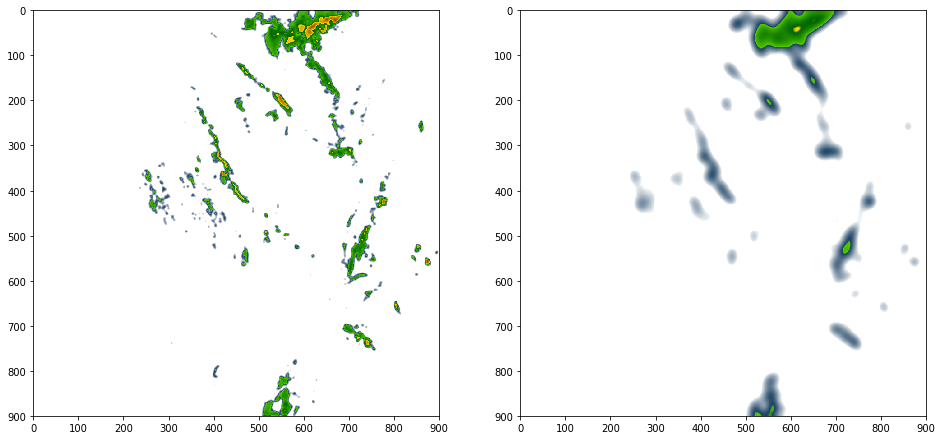

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(data1_smooth_weak,cmap=rc(),vmin=5,vmax=70)
ax[1].imshow(data1_smooth_strong,cmap=rc(),vmin=5,vmax=70)

## Isolierte Maxima finden
Als nächstes suchen wir isolierte Maxima, um einelne Zellen oder Zellkomplexe zu ermitteln. Um das zu vereinfachen, segmentieren wir die Daten zuerst und etikettieren sie.

In [20]:
data0_smooth_weak_binary = np.ma.masked_greater(data0_smooth_weak,0.1).mask*1
data0_smooth_strong_binary = np.ma.masked_greater(data0_smooth_strong,0.3).mask*1

In [21]:
data0_smooth_weak_labelled, nlabel_0w = ndi.label(data0_smooth_weak_binary)
data0_smooth_strong_labelled, nlabel_0s = ndi.label(data0_smooth_strong_binary)

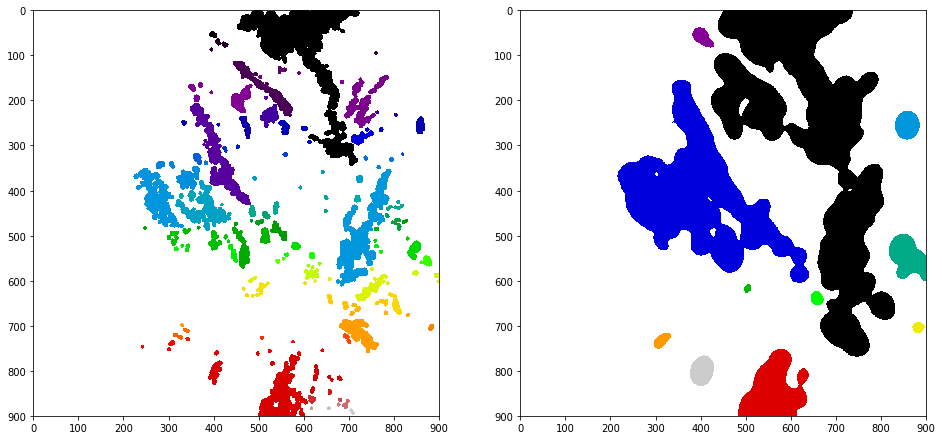

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(np.ma.masked_less(data0_smooth_weak_labelled,1),cmap='nipy_spectral')
ax[1].imshow(np.ma.masked_less(data0_smooth_strong_labelled,1),cmap='nipy_spectral')

In [23]:
data1_smooth_weak_binary = np.ma.masked_greater(data1_smooth_weak,0.1).mask*1
data1_smooth_strong_binary = np.ma.masked_greater(data1_smooth_strong,0.3).mask*1

In [24]:
data1_smooth_weak_labelled, nlabel_1w = ndi.label(data1_smooth_weak_binary)
data1_smooth_strong_labelled, nlabel_1s = ndi.label(data1_smooth_strong_binary)

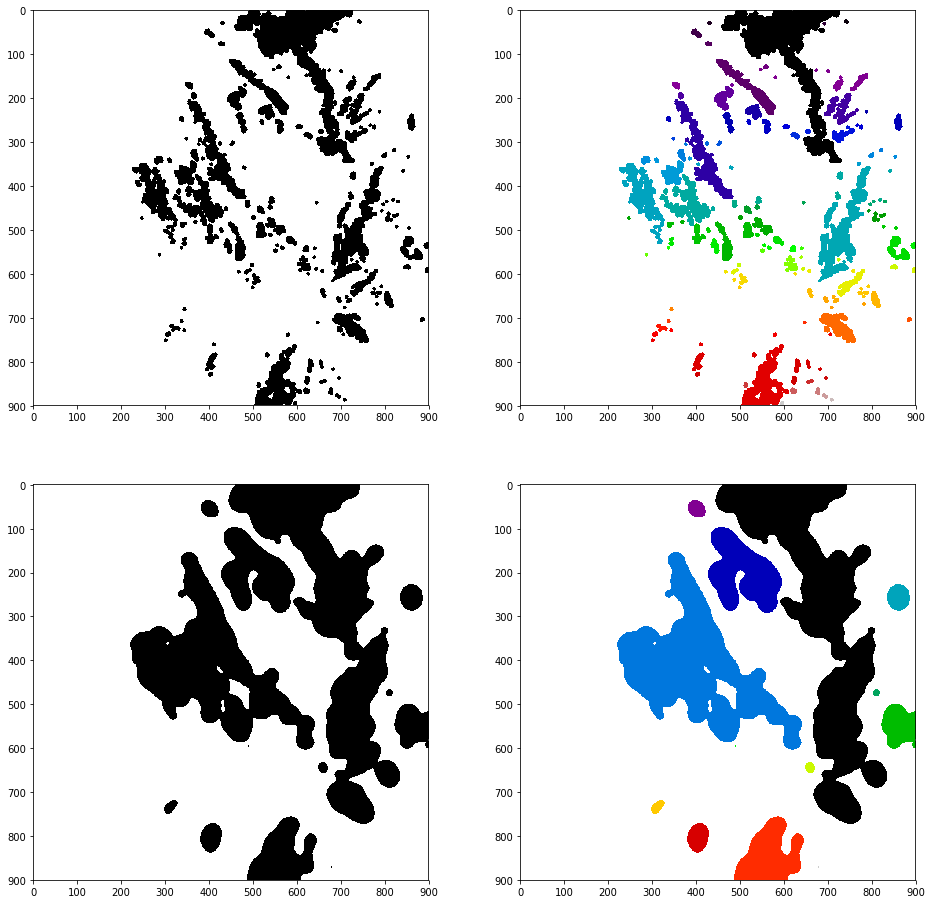

In [25]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(np.ma.masked_less(data1_smooth_weak_binary,1),cmap='nipy_spectral')
ax[0,1].imshow(np.ma.masked_less(data1_smooth_weak_labelled,1),cmap='nipy_spectral')
ax[1,0].imshow(np.ma.masked_less(data1_smooth_strong_binary,1),cmap='nipy_spectral')
ax[1,1].imshow(np.ma.masked_less(data1_smooth_strong_labelled,1),cmap='nipy_spectral')

Danach durchlaufen wir alle etikettierten Objekte und bestimmen deren lokale Maxima.

In [136]:
def get_maximum_location(data,data_labeled,obj,label,percentile=99,filter_size=20,return_value=True):
    """
    Find location of the maximum within a given object.
    
    Inputs:
        * data: array like, int or float
            data to find maximum in
        * data_labeled: array like, int
            data labeled to denote different objects
        * obj: slice returned by scipy.ndimage.find_objects
            boundaries of the current object
        * label: int
            label of the object to look for
        * percentile: int, default=99
            percentile to form a threshold to find local maxima above
        * filter_size: int, default=20
            size of the maximum filter used for the maximum detection
        * return_value: boolean, default=True
            switch to select if also the value of the selected maximum is to be returned
    """
    data_cutout = data[obj].copy()
    label_cutout = data_labeled[obj].copy()
    label_cutout[label_cutout!=label] = 0
    
    not_obj_locations = np.where(label_cutout==0) 
    
    threshold = np.percentile(data_cutout.ravel(),percentile)
    
    data_cutout[not_obj_locations] = 0
    data_cutout[np.where(data_cutout<threshold)]=0
    
    max_filter = ndi.maximum_filter(data_cutout,size=filter_size)
    
    max_location = np.where(max_filter==np.max(max_filter))
    
    max_r = np.min(max_location[0]) + ((np.max(max_location[0]) - np.min(max_location[0])) / 2.)
    max_c = np.min(max_location[1]) + ((np.max(max_location[1]) - np.min(max_location[1])) / 2.)
    
    r = obj[0].start + max_r
    c = obj[1].start + max_c
    
    if return_value==True:
        value = data[int(np.rint(r)),int(np.rint(c))]
        
        return (r,c,value)
    else:
        return (r,c)

In [64]:
obj_0w = ndi.measurements.find_objects(data0_smooth_weak_labelled)

In [137]:
maxima_0w = {i+1:[] for i in xrange(len(obj_0w))}

for i,o  in enumerate(obj_0w):
    max_loc = get_maximum_location(data0_smooth_weak, data0_smooth_weak_labelled,o,i+1)
    
    maxima_0w[i+1] = max_loc

In [138]:
maxima_0w

{1: (19.5, 667.5, 49.86763),
 2: (54.5, 398.5, 12.150959),
 3: (76.0, 425.0, 2.7820623),
 4: (87.0, 395.0, 1.0629116),
 5: (94.0, 760.0, 0.93786323),
 6: (192.5, 545.5, 48.83131),
 7: (132.5, 553.5, 5.3533454),
 8: (139.0, 589.0, 0.93786323),
 9: (148.0, 503.0, 1.125436),
 10: (164.5, 768.5, 13.695134),
 11: (222.5, 704.5, 24.639963),
 12: (159.0, 684.5, 2.1958475),
 13: (166.0, 370.5, 6.2515316),
 14: (210.5, 453.5, 27.399448),
 15: (172.5, 352.5, 11.103597),
 16: (182.0, 395.0, 0.93786323),
 17: (195.0, 362.5, 21.276438),
 18: (194.0, 516.0, 1.1462773),
 19: (361.5, 419.5, 43.652653),
 20: (231.5, 533.5, 32.152172),
 21: (226.0, 763.0, 0.9170218),
 22: (232.0, 804.0, 1.0003875),
 23: (255.5, 472.5, 15.794808),
 24: (250.5, 858.5, 38.573315),
 25: (249.5, 334.5, 4.5635476),
 26: (268.0, 559.5, 21.96414),
 27: (254.0, 410.0, 0.9587047),
 28: (262.0, 601.0, 10.099028),
 29: (264.5, 740.5, 1.6553229),
 30: (265.0, 771.5, 3.1486027),
 31: (288.5, 722.5, 19.943752),
 32: (292.0, 612.5, 1.7

In [139]:
def rearrange_maximum_dict(maximum_dict):
    if len(maximum_dict[maximum_dict.keys()[0]]) >= 3:
        max_rows = []
        max_cols = []
        max_values = []

        for k in list(maximum_dict.keys()):
            max_rows.append(maximum_dict[k][1])
            max_cols.append(maximum_dict[k][0])
            max_values.append(maximum_dict[k][2])
            
        out_dict = {'rows':max_rows,
                    'cols':max_cols,
                    'values':max_values}
            
    else:
        max_rows = []
        max_cols = []

        for k in list(maximum_dict.keys()):
            max_rows.append(maximum_dict[k][1])
            max_cols.append(maximum_dict[k][0])
            
        out_dict = {'rows':max_rows,
                    'cols':max_cols}
    
    return out_dict

In [140]:
maxima_0w_rearranged = rearrange_maximum_dict(maxima_0w)

In [141]:
obj_0s = ndi.measurements.find_objects(data0_smooth_strong_labelled,nlabel_0s)

In [142]:
maxima_0s = {i+1:[] for i in xrange(len(obj_0s))}

for i,o  in enumerate(obj_0s):
    max_loc = get_maximum_location(data0_smooth_strong, data0_smooth_strong_labelled,o,i+1)
    
    maxima_0s[i+1] = max_loc

In [143]:
maxima_0s_rearranged = rearrange_maximum_dict(maxima_0s)

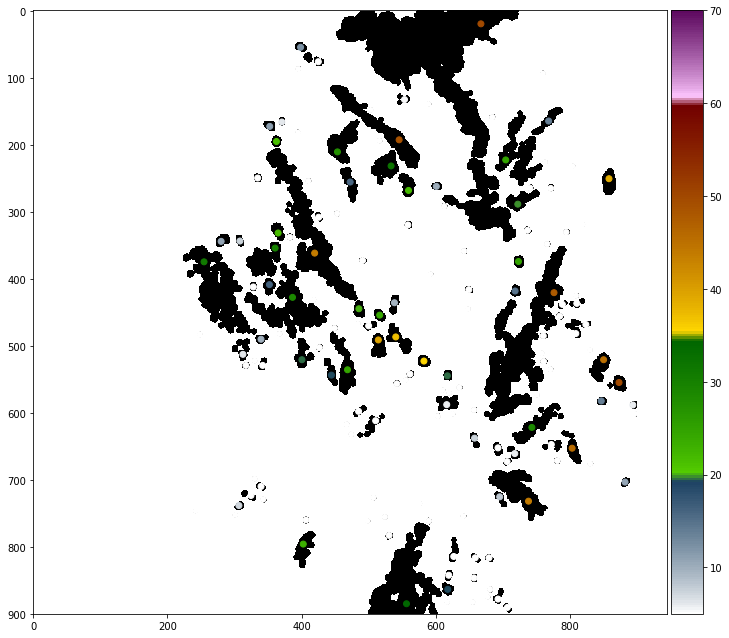

In [144]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(data0_smooth_weak_labelled,cmap='gray_r',vmin=0,vmax=1)

max_plot = ax.scatter(maxima_0w_rearranged['rows'],
                      maxima_0w_rearranged['cols'],
                      c=maxima_0w_rearranged['values'],cmap=rc(),vmin=5,vmax=70)
fc.colourbar(max_plot)

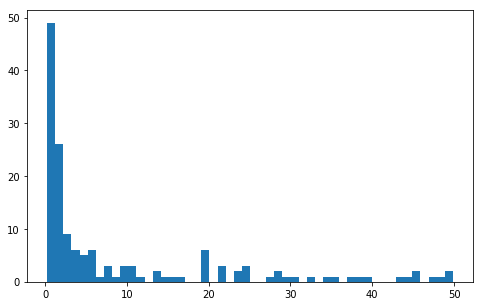

In [148]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
xx = ax.hist(maxima_0w_rearranged['values'],bins=50)

Die meisten lokalen Maxima haben Werte unter 10 dBZ und sind als solches wahrscheinlich uninteressant. Vielleicht sollte man sie ausmaskieren.

In [149]:
maxima_0s_rearranged = rearrange_maximum_dict(maxima_0s)

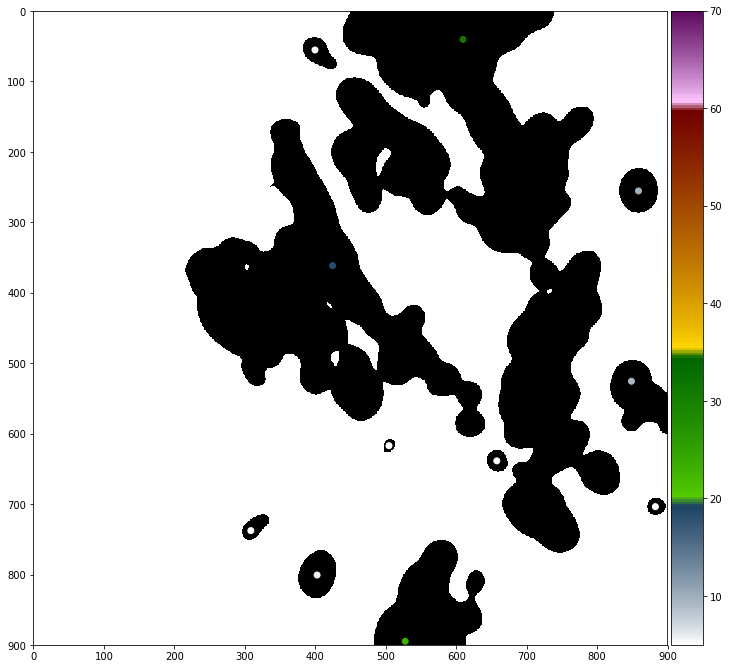

In [150]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(data0_smooth_strong_labelled,cmap='gray_r',vmin=0,vmax=1)

max_plot = ax.scatter(maxima_0s_rearranged['rows'],
                      maxima_0s_rearranged['cols'],
                      c=maxima_0s_rearranged['values'],cmap=rc(),vmin=5,vmax=70)
fc.colourbar(max_plot)

Das funktioniert soweit ganz gut. Dann machen wir das Ganze nochmal für den zweiten Zeitschritt.

In [151]:
obj_1w = ndi.measurements.find_objects(data1_smooth_weak_labelled)

In [152]:
maxima_1w = {i+1:[] for i in xrange(len(obj_1w))}

for i,o  in enumerate(obj_1w):
    max_loc = get_maximum_location(data1_smooth_weak, data1_smooth_weak_labelled,o,i+1)
    
    maxima_1w[i+1] = max_loc

In [153]:
maxima_1w_ra = rearrange_maximum_dict(maxima_1w)

In [154]:
obj_1s = ndi.measurements.find_objects(data1_smooth_strong_labelled)

In [155]:
maxima_1s = {i+1:[] for i in xrange(len(obj_1s))}

for i,o  in enumerate(obj_1s):
    max_loc = get_maximum_location(data1_smooth_strong, data1_smooth_strong_labelled,o,i+1)
    
    maxima_1s[i+1] = max_loc

In [156]:
maxima_1s_ra = rearrange_maximum_dict(maxima_1s)

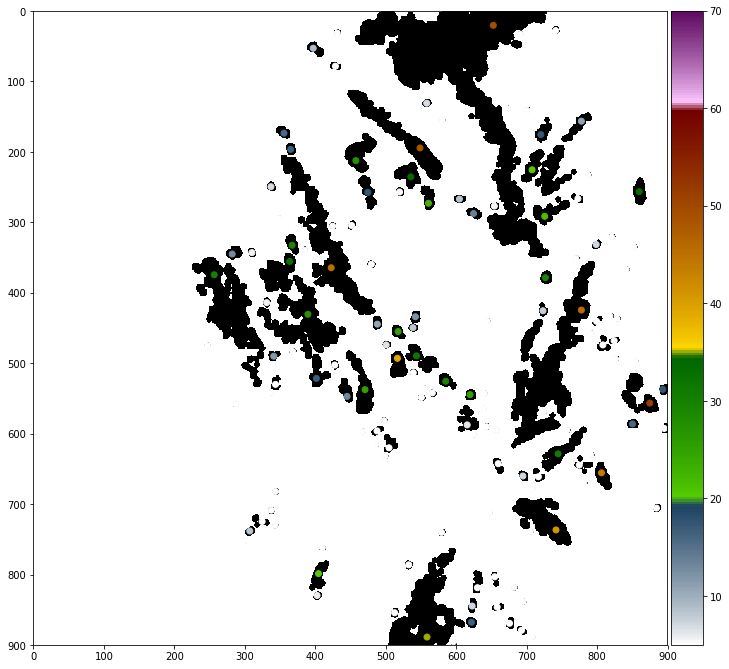

In [157]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(data1_smooth_weak_labelled,cmap='gray_r',vmin=0,vmax=1)

max_plot = ax.scatter(maxima_1w_ra['rows'],
                      maxima_1w_ra['cols'],
                      c=maxima_1w_ra['values'],cmap=rc(),vmin=5,vmax=70)
fc.colourbar(max_plot)

# fig,ax = plt.subplots(1,1,figsize=(12,12))
# ax.imshow(np.ma.masked_less(data1_smooth_weak,0.1),cmap='gray')
# ax.imshow(np.ma.masked_less(data1_smooth_weak_labelled,1),alpha=0.4)

# for p in maxima_1w:
#     ax.plot(maxima_1w[p][1],maxima_1w[p][0],'r+')

(0, 900)

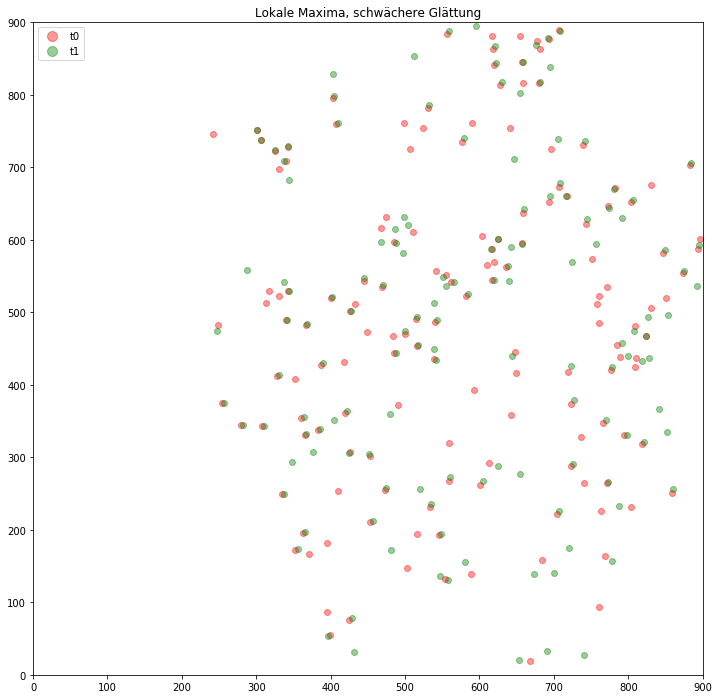

In [158]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.scatter(maxima_0w_rearranged['rows'],
           maxima_0w_rearranged['cols'],c='r',alpha=0.4,label='t0')
ax.scatter(maxima_1w_ra['rows'],
           maxima_1w_ra['cols'],c='g',alpha=0.4,label='t0')
ax.legend(handles=legend_elements, loc='upper left')
ax.set_title(u"Lokale Maxima, schwächere Glättung")
ax.set_xlim(0,900)
ax.set_ylim(0,900)

(0, 900)

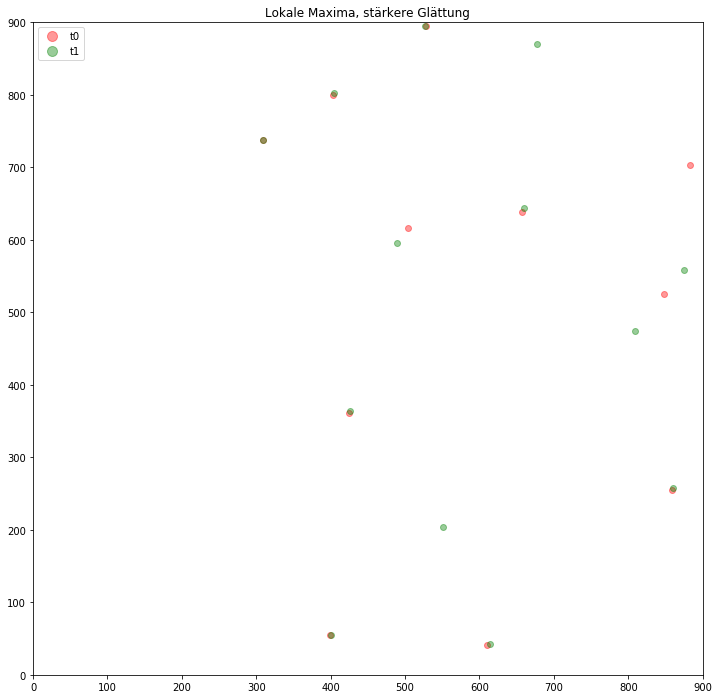

In [159]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.scatter(maxima_0s_rearranged['rows'],
           maxima_0s_rearranged['cols'],c='r',alpha=0.4,label='t0')
ax.scatter(maxima_1s_ra['rows'],
           maxima_1s_ra['cols'],c='g',alpha=0.4,label='t0')
   
ax.legend(handles=legend_elements, loc='upper left')
ax.set_title(u"Lokale Maxima, stärkere Glättung")
ax.set_xlim(0,900)
ax.set_ylim(0,900)

In [160]:
max_points_0w = np.zeros((900,900))

for p in maxima_0w.keys():
    ro = int(np.rint(maxima_0w[p][0]))
    co = int(np.rint(maxima_0w[p][1]))
    
    max_points_0w[ro,co] = p

In [161]:
def create_maxima_grid(max_points,shape):
    max_point_grid = np.zeros(shape)

    for p in max_points.keys():
        ro = int(np.rint(max_points[p][0]))
        co = int(np.rint(max_points[p][1]))

        max_point_grid[ro,co] = p
        
    return max_point_grid

In [162]:
maxima_grid_0w = create_maxima_grid(maxima_0w,(900,900))
maxima_grid_0s = create_maxima_grid(maxima_0s,(900,900))
maxima_grid_1w = create_maxima_grid(maxima_1w,(900,900))
maxima_grid_1s = create_maxima_grid(maxima_1s,(900,900))

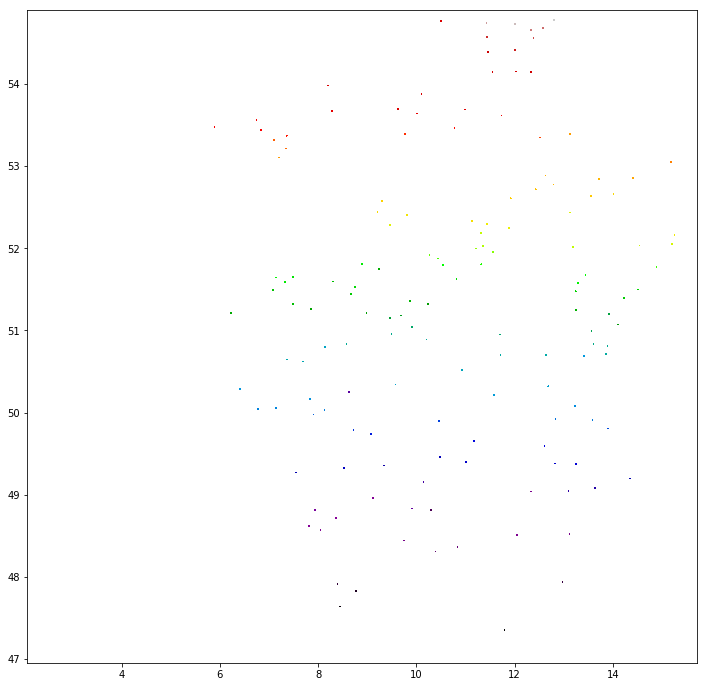

In [163]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.pcolormesh(r.lon,r.lat,np.ma.masked_less(maxima_grid_0w,1),cmap='nipy_spectral')

## 3 Auswahl passender Bewegungsvektoren}

Es gibt im Allgemeinen mehrere Möglichkeiten die Zellenmaxima über die Zeitschritte hinweg zu verbinden. Im Artikel werden folgende Kriterien angewendet:

1. die Magnitude der Bewegungsvektoren sollte kleiner sein als der 600&#8239;hPa-Wind aus Radiosondendaten
2. die Zunahme der Zellintensität sollte auf 45&#8239;mm&#8239;&middot;&#8239;(20&#8239;min)<sup>-1</sup> und die Intensitätsabnahme der Zellen solle auf 25&#8239;mm&#8239;&middot;&#8239;(20&#8239;min)<sup>-1</sup> beschränkt sein (Willies et al. 1994). Das entspricht 2,25&#8239;mm&#8239;&middot;&#8239;min<sup>-1</sup> und 1,25&#8239;&middot;&#8239;min<sup>-1</sup>. Für die 5-minütige Aufklösung von RADOLAN RX entspräche das 11,25&#8239; mm&middot;&#8239;(5&#8239;min)<sup>-1</sup> und 6,25&#8239;mm&#8239;&middot;&#8239;(5&#8239;min)<sup>-1</sup>. Mit der Marshall-Palmer-Formel (Z&#8239;=&#8239;200&#8239;&middot;&#8239;R<sup>1,4</sup>) umgerechnet, entspricht das etwa 43&#8239;dBZ&#8239;&middot;&#8239;(5&#8239;min)<sup>-1</sup> und 38&#8239;dBZ&#8239;&middot;&#8239;(5&#8239;min)<sup>-1</sup> und mit der Z-R-Beziehung für konvektiven Niederschlag nach WSR-88D (Z&#8239;=&#8239;300&#8239;&middot;&#8239;R<sup>1,4</sup>) entspräche das 40&#8239;dBZ&#8239;&middot;&#8239;(5&#8239;min)<sup>-1</sup> und 36&#8239;dBZ&#8239;&middot;&#8239;(5&#8239;min)<sup>-1</sup>.
3. nur Vektoren innerhalb eines bestimmten Umkreises um das Zellmaximum zu t0 werden einbezogen (im Artikel 200&#8239;km, hier folglich 50&#8239;km), da angenommen werden kann, dass die Zellen in einem bestimmten Umkreis die gleiche Bewegungsrichtung haben
4. um unnatürliche viele Zellaufteilungen zu vermeiden wird nur ein Bewegungsvektor ausgewählt, dafür wird zwischen allen möglichen Vektoren <i>v&#8407;</i><sub>j</sub> eine mittlere Quadratische Abwiechung (MQA) der Vektorkomponenten berechnet. Aus der Kombination mit der kleinsten MQA wird ein mittlerer Vektor <i>v&#8407;</i><sub>m</sub> berechnet. 
5. Das wird mit allen möglichen Vektoren <i>v&#8407;</i><sub>j</sub> mit einem zusätzlichen Kriterium durchgeführt, um Ausreißer zu vermeiden: |<i>v&#8407;</i><sub>j</sub> - <i>kv&#8407;</i><sub>m</sub>| - |k<i>v&#8407;</i><sub>m</sub>| &leq; 0, wobei 1,2 &leq; <i>k</i> &leq; 3,5. Der Wert <i>k</i> wird auf Basis von |<i>v&#8407;</i><sub>m</sub>| so gewählt, dass <i>k</i> groß ist, wenn <i>v&#8407;</i><sub>m</sub> klein ist und umgekehrt. Es werden nur Vektoren, die inneralb des Kreisradius |<i>kv&#8407;</i><sub>m</sub>| liegen akzeptiert, weil diese nicht zu stark von <i>v&#8407;</i><sub>m</sub> abweichen.

Der erste Schritt ist mangels Daten leider nicht durchführbar, aber wir können mal die anderen versuchen.

Zuerst ermitteln wir die Koordinaten, die den Radius um jedes Maximum abdecken. Den Radius setzten wir analog zum Artikel erstmal auf 50 km. Die Zeitauflösung im Artikel war 20 min und der Radius 200 km. Da unsere Zeitauflösung viermal höher ist, nehmen wir nur ein Viertel des Abstandes.

In [ ]:
radius = 50

radius_limits_0w ={k:[] for k in maxima_0w.keys()}

for k in maxima_0w.keys():
    r_min = int(np.rint(np.clip(maxima_0w[k][0] - radius,0,899)))
    r_max = int(np.rint(np.clip(maxima_0w[k][0] + radius,0,899)))
    c_min = int(np.rint(np.clip(maxima_0w[k][1] - radius,0,899)))
    c_max = int(np.rint(np.clip(maxima_0w[k][1] + radius,0,899)))
    
    radius_limits_0w[k] = (slice(r_min,r_max),slice(c_min,c_max))

In [165]:
radius_limits_0w

{1: (slice(0, 70, None), slice(618, 718, None)),
 2: (slice(4, 104, None), slice(348, 448, None)),
 3: (slice(26, 126, None), slice(375, 475, None)),
 4: (slice(37, 137, None), slice(345, 445, None)),
 5: (slice(44, 144, None), slice(710, 810, None)),
 6: (slice(142, 242, None), slice(496, 596, None)),
 7: (slice(82, 182, None), slice(504, 604, None)),
 8: (slice(89, 189, None), slice(539, 639, None)),
 9: (slice(98, 198, None), slice(453, 553, None)),
 10: (slice(114, 214, None), slice(718, 818, None)),
 11: (slice(172, 272, None), slice(654, 754, None)),
 12: (slice(109, 209, None), slice(634, 734, None)),
 13: (slice(116, 216, None), slice(320, 420, None)),
 14: (slice(160, 260, None), slice(404, 504, None)),
 15: (slice(122, 222, None), slice(302, 402, None)),
 16: (slice(132, 232, None), slice(345, 445, None)),
 17: (slice(145, 245, None), slice(312, 412, None)),
 18: (slice(144, 244, None), slice(466, 566, None)),
 19: (slice(312, 412, None), slice(370, 470, None)),
 20: (slice(1

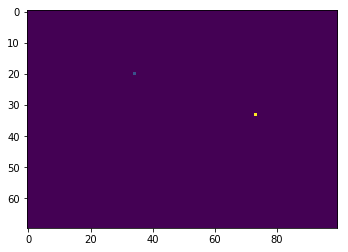

In [166]:
plt.imshow(maxima_grid_1w[radius_limits_0w[1]])

Dann sehen wir uns an, welche Maxima des nächsten Zeitschrittes innerhalb dieses Ausschnittes liegen.

In [174]:
p_t1_loc = np.where(maxima_grid_1w[radius_limits_0w[1]]!=0)

In [175]:
p_t1 = []   

# reformat point_locations to (row, column)
if len(p_t1_loc[0]) > 1:
    points = []

    for i in xrange(len(p_t1_loc[0])):
        p_t1.append(np.array([p_t1_loc[0][i], p_t1_loc[1][i]]))

else:
    p_t1 = [np.array([p_t1_loc[0][0], p_t1_loc[1][0]])]

In diesem Fall, hätten wir zwei Kandidaten. Das heißt, wir müssen einen geeigneten auswählen.

In [177]:
p_t0_loc = np.where(maxima_grid_0w[radius_limits_0w[1]]!=0)

In [178]:
p_t0 = []   

# reformat point_locations to (row, column)
if len(p_t0_loc[0]) > 1:
    points = []

    for i in xrange(len(p_t0_loc[0])):
        p_t0.append(np.array([p_t0_loc[0][i], p_t0_loc[1][i]]))

else:
    p_t0 = [np.array([p_t0_loc[0][0], p_t0_loc[1][0]])]

In [179]:
print p_t0, p_t1

[array([20, 50])] [array([20, 34]), array([33, 73])]


Dazu ermitteln wir uns zunächst die Ortsvektoren der Punkte relativ zum Punkt in t0

In [180]:
loc_vec = []

for p in p_t1:
    vec = np.array([p[0]- p_t0[0][0],p[1] - p_t0[0][1]])
    loc_vec.append(vec)

In [181]:
print loc_vec

[array([  0, -16]), array([13, 23])]


In [182]:
def RMS(vector):
    
    rms = np.sqrt((vector[0]**2 + vector[1]**2)/2)
    
    return rms

Dann berechnen wir die MQA der Vektoren.

In [183]:
print RMS(loc_vec[0]), RMS(loc_vec[1])

11.313708498984761 18.681541692269406


Da wir nur zwei Vektoren haben, berechnen wir den mittleren Vektor aus ihnen.

In [184]:
v_m = 0.5 * (loc_vec[0] + loc_vec[1])
print v_m

[6.5 3.5]


In [194]:
loc_vec[0],loc_vec[1]

(array([  0, -16]), array([13, 23]))

In [185]:
v_m_norm = np.linalg.norm(v_m)

In [186]:
1/v_m_norm

0.13545709229571928

In [189]:
k*v_m[0]

19.5

Jetzt haben wir im Prinzip immer noch zwei Vektoren, die in Frage kommen.

In [245]:
k = 2.2

In [246]:
circle1= plt.Circle((k*v_m[1], k*v_m[0]), k*v_m_norm, color='k',alpha=0.2)

Text(7,12,'$k\\vec{v}_\\mathrm{m}$')

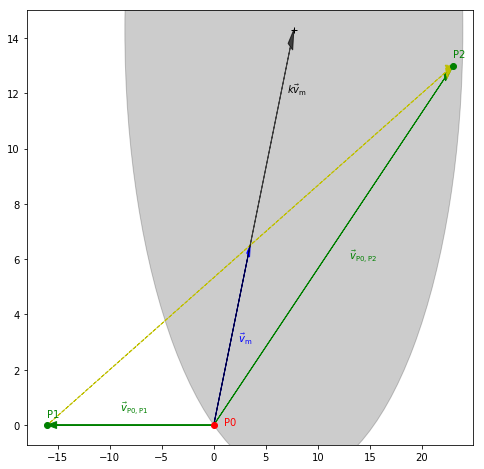

In [247]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.add_artist(circle1)
ax.plot(0,0,'ro')
ax.text(1,0,'P0', transform=ax.transData ,color='r')

ax.plot(loc_vec[0][1],loc_vec[0][0],'go')
ax.text(loc_vec[0][1],loc_vec[0][0]+0.3,'P1', transform=ax.transData ,color='g')

ax.plot(loc_vec[1][1],loc_vec[1][0],'go')
ax.text(loc_vec[1][1],loc_vec[1][0]+0.3,'P2', transform=ax.transData ,color='g')

ax.arrow(0,0,loc_vec[0][1],loc_vec[0][0],color='g',head_length=0.9,head_width=0.25,length_includes_head=True)
ax.text(-9,0.5,r'$\vec{v}_\mathrm{P0,P1}$', transform=ax.transData ,color='g')

ax.arrow(0,0,loc_vec[1][1],loc_vec[1][0],color='g',head_length=0.9,head_width=0.25,length_includes_head=True)
ax.text(13,6,r'$\vec{v}_\mathrm{P0,P2}$', transform=ax.transData ,color='g')

ax.arrow(0,0,v_m[1],v_m[0],color='b',head_length=0.4,head_width=0.3,length_includes_head=True)
ax.text(2.3,3,r'$\vec{v}_\mathrm{m}$', transform=ax.transData ,color='b')

ax.arrow(loc_vec[0][1],loc_vec[0][0],
         loc_vec[1][1]-loc_vec[0][1],
         loc_vec[1][0]-loc_vec[0][0],
         color='y',head_length=0.7,head_width=0.5,length_includes_head=True,linestyle='dashed')

ax.plot(k*v_m[1],k*v_m[0],'k+')
ax.arrow(0,0,k*v_m[1],k*v_m[0],head_length=0.7,head_width=0.5,length_includes_head=True,color='k',alpha=0.7)
ax.text(7,12,r'$k\vec{v}_\mathrm{m}$', transform=ax.transData ,color='k')

In diesem Fall würde der rechte Vektor gewählt.

In [248]:
def RMS_vectors(vector1, vector2):
    """
    Calculate root mean squared of the components of two vectors.
    
    Inputs:
        * vector1: array like, int or float
        * vector2: array like, int or float, same shape as vector1
    Returns:
        * vector norm of the rms
    """
    rms = np.sqrt((vector1**2+vector2**2)/ vector1.shape[0])
    
    return np.linalg.norm(rms)

In [255]:
def determine_cutout_slice(maxima,maximum_id,lower_limit,upper_limit,radius=50):
    r_min = int(np.rint(np.clip(maxima[maximum_id][0] - radius,lower_limit,upper_limit)))
    r_max = int(np.rint(np.clip(maxima[maximum_id][0] + radius + 1,lower_limit,upper_limit)))
    c_min = int(np.rint(np.clip(maxima[maximum_id][1] - radius,lower_limit,upper_limit)))
    c_max = int(np.rint(np.clip(maxima[maximum_id][1] + radius + 1,lower_limit,upper_limit)))
    
    cutout_slice = (slice(r_min,r_max),slice(c_min,c_max))
    
    return cutout_slice

In [250]:
def extract_point_locations(grid,limits,point_id,fill=False,return_cutout=True):
    cutout = grid[limits].copy()
    
    if fill==True:
        cutout[np.where(cutout!=point_id)] = 0
        
    point_locations = np.where(cutout!=0)
    
    # reformat point_locations to (row, column)
    if len(point_locations[0]) > 1:
        points = []

        for i in xrange(len(point_locations[0])):
            points.append(np.array([point_locations[0][i], point_locations[1][i]]))

    else:
        points = [np.array([point_locations[0][0], point_locations[1][0]])]
    
    if return_cutout==True:
        return cutout, points
    else:
        return points

In [251]:
def calculate_mean_vector(vector0,vector1):
    """
    Calculate the mean vector of two vectors.
    
    Input:
        * vector0: numpy array, float or int
        * vector1: numpy array, float or int
    
    Returns:
        * mean_vector: numpy array, float or int
    """
    
    mean_vector = 0.5 * (vector0 + vector1)
    
    return mean_vector

In [252]:
def get_location_vector(vector, origin_vector):
    location_vector = vector - origin_vector
    
    return location_vector

In [253]:
def determine_unique_combinations(element_list):
    combinations = []

    for v in element_list:
        for w in element_list:
            if not v == w:
                if not '{}_{}'.format(w,v) in combinations:
                    combinations.append('{}_{}'.format(v,w))
                    
    return combinations

In [254]:
def calculate_vector_pair_deviations(vectors, vector_combination_list):
    deviations = {v:[] for v in vector_combination_list}
        
    for v in vector_combination_list:
        v0 = v.split('_')[0]
        v1 = v.split('_')[1]

        deviations[v] = RMS_vectors(vectors[v0],vectors[v1])
        
    return deviations

In [136]:
def select_next_vector(max_grid_t0,max_grid_t1,maxima_dict_t0,maxima_dict_t1,
                       maximum_id,search_radius=50,maximum_decay=35,maximum_increase=40):
    """
    Select the vector which is the sjift to the next object location in time.
    
    Inputs:
        * max_grid_t0: numpy array, int
            numpy array with the locations of the maxima in the first time step labeled
        * max_grid_t1: numpy array, int
            numpy array with the locations of the maxima in the second time step labeled
        * maxima_dict_t0: dictionary
            dictionary with the labels, locations and values of the maxima in the first time step
        * maxima_dict_t1: dictionary
            dictionary with the labels, locations and values of the maxima in the second time step
        * maximum_id: int
            label of the maximum to be analysed
        * search_radius: int, default = 50
            radius of grid steps to be looked in for objects to connect to the object of the first time step
        * maximum_decay: float or int, default = 35
            maximum decay of intensity of an object can have to still be considered in the next time step
        * maximum_increase: float or int, default = 40
            maximum increase of intensity an object can have to still be considered in the next time step
    Returns:
        * shift_vector: numpy array
    """
    
    # get limits of the cutout   
    cutout_limits = determine_cutout_slice(maxima_dict_t0,maximum_id,0,np.max(max_grid_t0.shape)-1)
    
    # get cutouts and coordinates of the points
    cutout_t0, p_t0 = extract_point_locations(max_grid_t0,cutout_limits,maximum_id,True) 
    cutout_t1, p_t1 = extract_point_locations(max_grid_t1,cutout_limits,maximum_id,False) 
    
        
    # check the possible new objects for increase or decay of intensity:
    # get labels of possible in the second time step
    labels_t1 = np.unique(cutout_t1)[1:]
    
    # get values of those labels
    obj_t1_values = []
    
    reference_value = maxima_dict_t0[maximum_id][2]
    for l in labels_t1:
        value = maxima_dict_t1[l][2]
        
        if value - reference_value < maximum_increase and reference_value - value < maximum_decay:
            obj_t1_values.append((l,value))
        
    
    
    
    # get the location vectors to the points in t1 relative to the point in t0
    loc_vec = dict()

    for i,p in enumerate(p_t1):
        vec = get_location_vector(p,p_t0)
        loc_vec['v{}'.format(i)] = vec
    
    if len(list(loc_vec.keys())) == 1:
        return loc_vec[loc_vec.keys()[0]][0]
    else:
        # run through all vector pairs in t1 and store all unique combinations
        vector_combinations = determine_unique_combinations(list(loc_vec.keys()))

        # run through the combinations and calculate RMS
        deviations = calculate_vector_pair_deviations(loc_vec,vector_combinations)    

        # get combination with minimum RMS
        min_idx = np.where(np.array(deviations.values())==np.min(np.array(deviations.values())))

        min_combi = deviations.keys()[min_idx[0][0]]

        # calculate mean vector of that combination
        v0 = min_combi.split('_')[0]
        v1 = min_combi.split('_')[1]

        v_m = calculate_mean_vector(loc_vec[v0],loc_vec[v1])

        # select one vector based on a circle around the mean vector and a factor

        for k in np.arange(1.2,3.5,0.1):
            vector_evaluation = dict()

            for v in [v0,v1]:
                evaluation = np.linalg.norm(loc_vec[v] - k*v_m) - np.linalg.norm(k*k*v_m)
                vector_evaluation[v] = evaluation

            if np.any(np.array(vector_evaluation.values()) <= 0):
                cand_idx = np.where(np.array(vector_evaluation.values()) <= 0)

                cand_vec = np.array(vector_evaluation.keys())[cand_idx]

                if len(cand_vec[0]) > 1:

                    rms = {v:[] for v in [v0,v1]}
                    for cand in cand_vec:
                        rms[cand] = RMS_vectors(loc_vec[cand],v_m)

                    min_idx = np.where(np.array(rms) == np.min(np.array(rms)))

                    cand_vec = np.array(rms.keys())[min_idx]

                return loc_vec[cand_vec[0]][0]
            else:
                continue

In [ ]:
maxima_dict_t0 = maxima_0s
maxima_dict_t1 = maxima_0s
max_grid_t0 = maxima_grid_0s
max_grid_t1 = maxima_grid_1s
maximum_id=1

In [137]:
cutout_limits = determine_cutout_slice(maxima_dict_t0,maximum_id,0,np.max(max_grid_t0.shape)-1)
    
    # get cutouts and coordinates of the points
    cutout_t0, p_t0 = extract_point_locations(max_grid_t0,cutout_limits,maximum_id,True) 
    cutout_t1, p_t1 = extract_point_locations(max_grid_t1,cutout_limits,maximum_id,False) 
    
        
    # check the possible new objects for increase or decay of intensity:
    # get labels of possible in the second time step
    labels_t1 = np.unique(cutout_t1)[1:]
    
    # get values of those labels
    obj_t1_values = []
    
    reference_value = maxima_dict_t0[maximum_id][2]
    for l in labels_t1:
        value = maxima_dict_t1[l][2]
        
        if value - reference_value < maximum_increase and reference_value - value < maximum_decay:
            obj_t1_values.append((l,value))

In [138]:
shift_vectors

{1: array([  0, -16]),
 2: array([-1, -1]),
 3: array([2, 3]),
 4: array([nan, nan]),
 5: array([nan, nan]),
 6: array([2, 2]),
 7: array([-1,  4]),
 8: array([16, -9]),
 9: array([ 24, -22]),
 10: array([-8, 10]),
 11: array([4, 4]),
 12: array([-20, -11]),
 13: array([  8, -14]),
 14: array([2, 4]),
 15: array([2, 4]),
 16: array([nan, nan]),
 17: array([-21,  -6]),
 18: array([nan, nan]),
 19: array([-10, -15]),
 20: array([4, 2]),
 21: array([ 7, 24]),
 22: array([  1, -17]),
 23: array([2, 2]),
 24: array([6, 2]),
 25: array([0, 3]),
 26: array([5, 0]),
 27: array([nan, nan]),
 28: array([5, 3]),
 29: array([nan, nan]),
 30: array([1, 0]),
 31: array([4, 4]),
 32: array([-25,  -8]),
 33: array([ 2, -1]),
 34: array([-2, -2]),
 35: array([nan, nan]),
 36: array([2, 1]),
 37: array([0, 2]),
 38: array([nan, nan]),
 39: array([2, 4]),
 40: array([ -6, -15]),
 41: array([1, 2]),
 42: array([-1,  2]),
 43: array([3, 4]),
 44: array([-22,   7]),
 45: array([0, 2]),
 46: array([4, 2]),
 

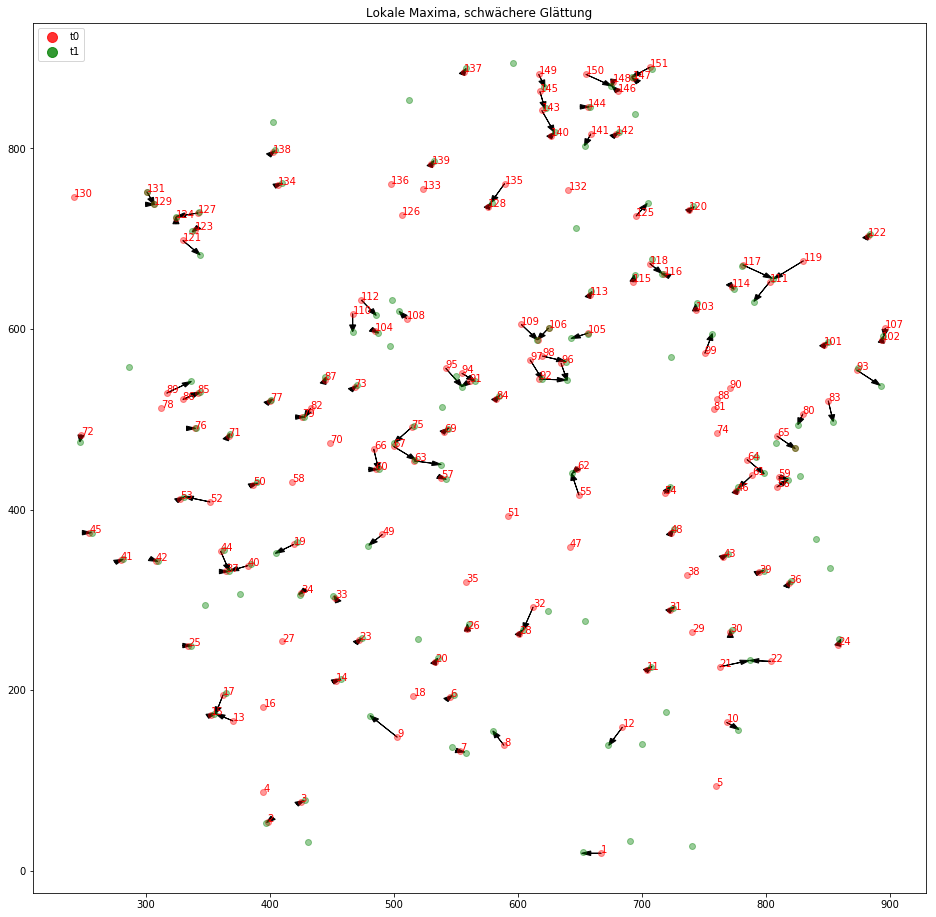

In [139]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
for p in maxima_0w:
    ax.plot(maxima_0w[p][1],maxima_0w[p][0],'ro',alpha=0.4)
for p in maxima_1w:
    ax.plot(maxima_1w[p][1],maxima_1w[p][0],'go',alpha=0.4)
    
legend_elements = [Line2D([0], [0], marker='o', color='r', label='t0',
                          markerfacecolor='r', markersize=10,alpha=0.8,linestyle='none'),
                   Line2D([0], [0], marker='o', color='g', label='t1',
                          markerfacecolor='g', markersize=10,alpha=0.8,linestyle='none'),
                  ]
ax.legend(handles=legend_elements, loc='upper left')
ax.set_title(u"Lokale Maxima, schwächere Glättung")

for k in shift_vectors.keys():
    try:
        ax.arrow(maxima_0w[k][1],maxima_0w[k][0],shift_vectors[k][1],shift_vectors[k][0],color='black',
                 head_width=5,length_includes_head=True)
        ax.text(maxima_0w[k][1],maxima_0w[k][0],k,color='red')
    
    except:
        continue

Das scheint meistens ganz gut zu funktionieren. 

In [142]:
shift_vectors_s = {k:[] for k in maxima_0s.keys()}

for k in maxima_0s.keys():
    #try:
        print k
        vec = select_vector_pair(maxima_grid_0s,
                                 maxima_grid_1s,
                                 maxima_0s,k,search_radius=50)

        shift_vectors_s[k] = vec
    #except:
    #    shift_vectors_s[k] = np.array([np.nan,np.nan])

1
2
3
4
5


IndexError: index 0 is out of bounds for axis 0 with size 0

In [143]:
max_grid_t0 = maxima_grid_0s
max_grid_t1 = maxima_grid_1s
max_dict = maxima_0s
max_id = 5
search_radius=50

In [150]:
maxima_0s

{1: (40.5, 609.5),
 2: (55.5, 399.5),
 3: (361.5, 424.5),
 4: (255.5, 858.5),
 5: (525.5, 848.5),
 6: (617.0, 504.5),
 7: (638.5, 657.5),
 8: (703.5, 882.5),
 9: (737.5, 308.5),
 10: (894.5, 527.5),
 11: (800.5, 402.5)}

In [146]:
cutout_limits = determine_cutout_slice(maxima_dict,max_id,0,np.max(max_grid_t0.shape)-1)

In [147]:
cutout_t0, p_t0 = extract_point_locations(max_grid_t0,cutout_limits,max_id,True)

IndexError: index 0 is out of bounds for axis 0 with size 0

/home/lenk/.local/lib/python2.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/lenk/.local/lib/python2.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/lenk/.local/lib/python2.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/lenk/.local/lib/python2.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/lenk/.local/lib/python2.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/lenk/.local/lib/python2.7/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


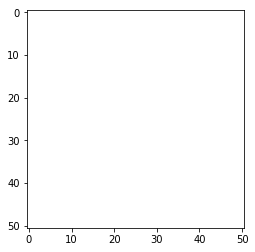

In [151]:
plt.imshow(np.ma.masked_less(maxima_grid_0s[cutout_limits],1))

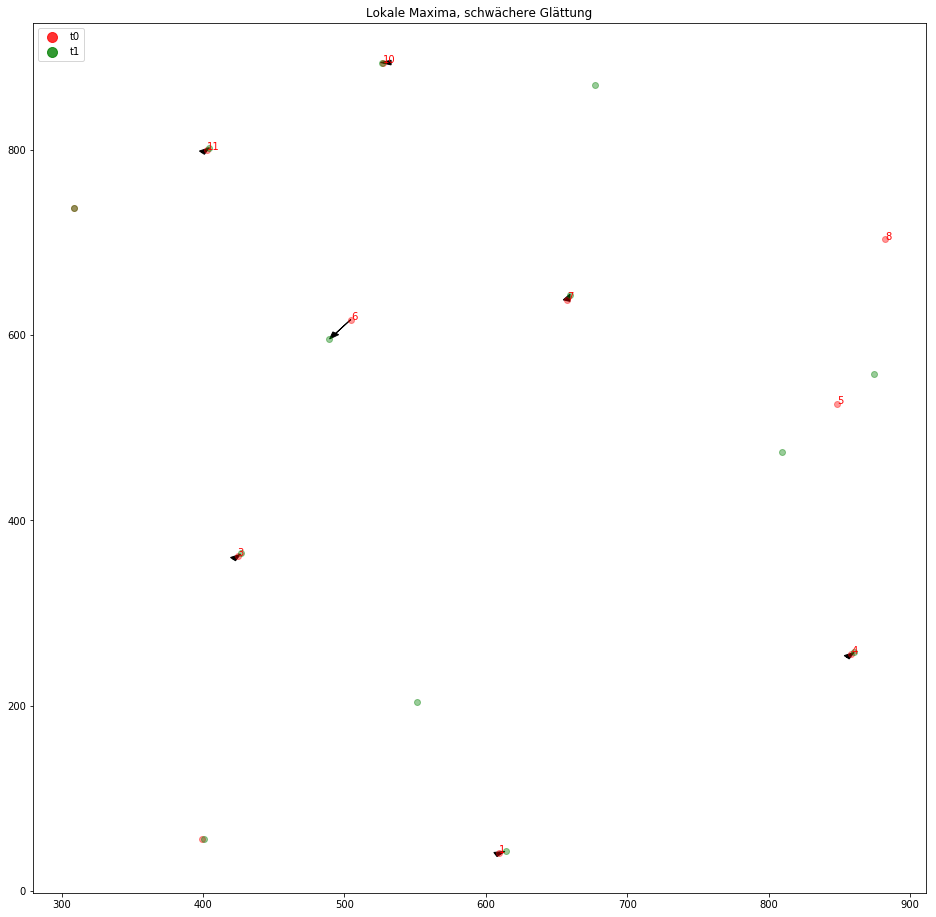

In [141]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
for p in maxima_0s:
    ax.plot(maxima_0s[p][1],maxima_0s[p][0],'ro',alpha=0.4)
for p in maxima_1s:
    ax.plot(maxima_1s[p][1],maxima_1s[p][0],'go',alpha=0.4)
    
legend_elements = [Line2D([0], [0], marker='o', color='r', label='t0',
                          markerfacecolor='r', markersize=10,alpha=0.8,linestyle='none'),
                   Line2D([0], [0], marker='o', color='g', label='t1',
                          markerfacecolor='g', markersize=10,alpha=0.8,linestyle='none'),
                  ]
ax.legend(handles=legend_elements, loc='upper left')
ax.set_title(u"Lokale Maxima, schwächere Glättung")

for k in shift_vectors.keys():
    try:
        ax.arrow(maxima_0s[k][1],maxima_0s[k][0],shift_vectors_s[k][1],shift_vectors_s[k][0],color='black',
                 head_width=5,length_includes_head=True)
        ax.text(maxima_0s[k][1],maxima_0s[k][0],k,color='red')
    
    except:
        continue